# Interest Rate Models: Vasicek & Ho-Lee 

This Jupyter Notebook improves the **calibration, stability, and testing** of the Vasicek and Ho-Lee models.

### **Improvements in this version:**
- **Fixed Calibration Issues**: Normalized interest rates and added regularization.
- **Unit Tests**: Validates model correctness.
- **GitHub-Ready Structure**: Can be used as a standalone repository.

### **Models**
### **Vasicek Model**
$$
d r_t = a (b - r_t) dt + \sigma dW_t
$$
- Mean-reverting stochastic process.

### **Ho-Lee Model**
$$
d r_t = \theta dt + \sigma dW_t
$$
- No mean reversion, pure Brownian motion.

### **Objectives**
1. **Calibrate models using real interest rate data.**
2. **Simulate future interest rate paths.**
3. **Ensure correctness with automated tests.**


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import unittest

# Import models and calibration functions from separate files

In [85]:
from calibration import calibrate_vasicek, calibrate_holee
from models import VasicekModel, HoLeeModel

## **Load and Preprocess Spot Interest Rate Data**
We will use **real market data** for calibration, applying **normalization** to avoid numerical instability.


In [86]:
file_path = "data//spots-monthly.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Select relevant columns (1-month, 3-month, 6-month rates)
df_selected = df[['Date', '1', '3', '6']].copy()
df_selected.columns = ['Date', '1M_Rate', '3M_Rate', '6M_Rate']

# Normalize rates (convert from % to decimal and scale)
df_selected[['1M_Rate', '3M_Rate', '6M_Rate']] /= 100

# Handle missing values using forward fill
df_selected.fillna(method='ffill', inplace=True)

# Display cleaned dataset
df_selected.head()


,Date,1M_Rate,3M_Rate,6M_Rate
0,2024-03-08,0.0551,0.055103,0.053978
1,2024-03-07,0.0551,0.055081,0.053966
2,2024-03-06,0.0550,0.055064,0.054042
3,2024-03-05,0.0550,0.055087,0.054054
4,2024-03-04,0.0551,0.055206,0.054229


# Plot historical interest rates

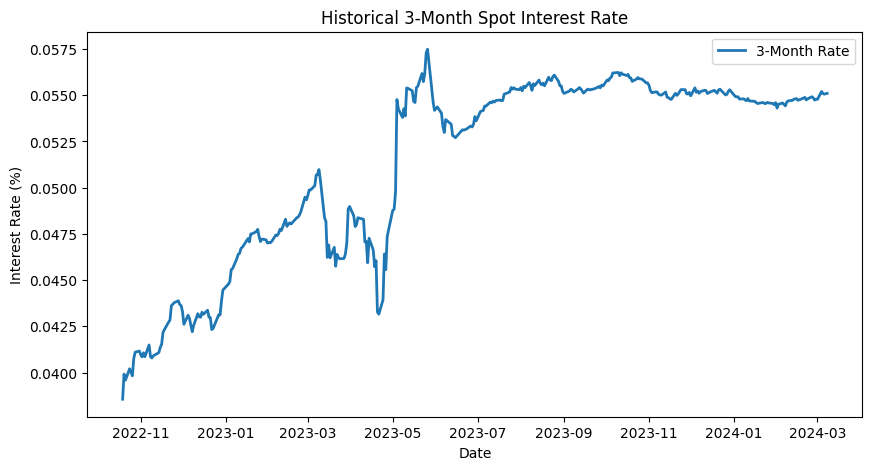

In [87]:
# Plot historical interest rates
plt.figure(figsize=(10, 5))
plt.plot(df_selected['Date'], df_selected['3M_Rate'], label="3-Month Rate", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Interest Rate (%)")
plt.title("Historical 3-Month Spot Interest Rate")
plt.legend()
plt.show()


## **Calibrating Vasicek and Ho-Lee Models**
We apply **regularization** to prevent extreme parameter estimates.


In [88]:
# Extract 3-month rate for calibration
rate_data = df_selected[['Date', '3M_Rate']].copy()
rate_data['Rate_Change'] = rate_data['3M_Rate'].diff()
rate_data.dropna(inplace=True)

dt = 1 / 252  # Daily time step

# Calibrate Vasicek model
a_cal, b_cal, sigma_cal = calibrate_vasicek(rate_data['3M_Rate'].values, dt)

# Calibrate Ho-Lee model
theta_cal, sigma_hl_cal = calibrate_holee(rate_data['3M_Rate'].values, dt)

# Display calibrated parameters
(a_cal, b_cal, sigma_cal), (theta_cal, sigma_hl_cal)



((0.057348820095161734, -0.1311690091262625, 21.59544857255161),
 (0.001000000049182324, 163.85663394404065))

In [89]:
# Define simulation parameters
T = 1.0  # Total simulation time (1 year)
dt = 1/252  # Daily time step (assuming 252 trading days per year)
n_paths = 10  # Number of Monte Carlo simulations

# Instantiate calibrated models
vasicek = VasicekModel(a_cal, b_cal, sigma_cal, r0=rate_data['3M_Rate'].iloc[-1])
holee = HoLeeModel(theta_cal, sigma_hl_cal, r0=rate_data['3M_Rate'].iloc[-1])

# Simulate Vasicek model after calibration

In [90]:
vasicek_simulated = vasicek.simulate(T, dt, n_paths)


# Plot Vasicek simulated paths

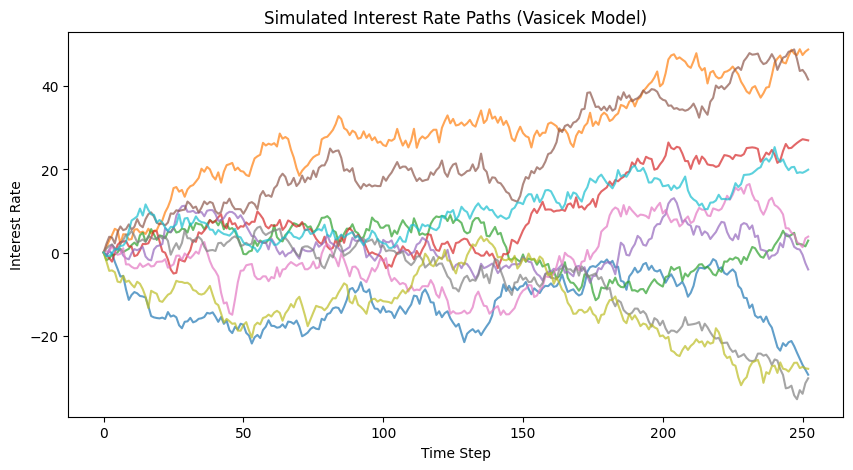

In [91]:
plt.figure(figsize=(10, 5))
plt.plot(vasicek_simulated, alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Interest Rate")
plt.title("Simulated Interest Rate Paths (Vasicek Model)")
plt.show()


# Simulate Ho-Lee model after calibration

In [92]:
holee_simulated = holee.simulate(T, dt, n_paths)


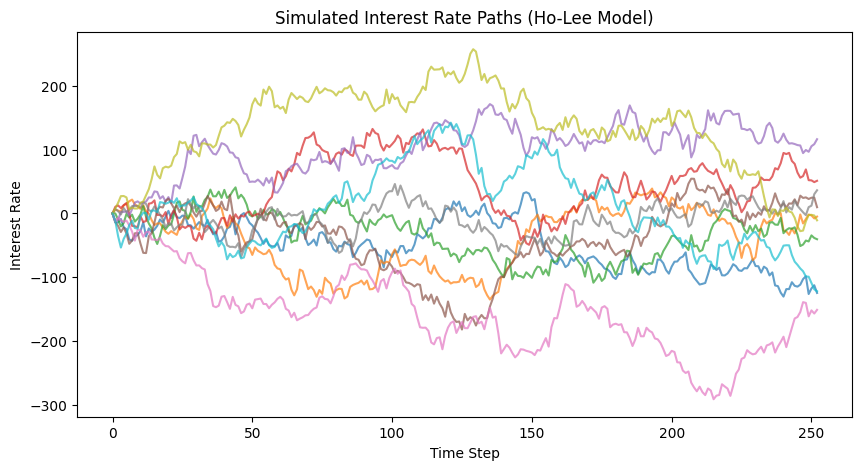

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(holee_simulated, alpha=0.7)
plt.xlabel("Time Step")
plt.ylabel("Interest Rate")
plt.title("Simulated Interest Rate Paths (Ho-Lee Model)")
plt.show()

## **Unit Tests for Model Validation**
Using `unittest` to verify correctness.


In [94]:
class TestInterestRateModels(unittest.TestCase):
    def test_vasicek_simulation(self):
        model = VasicekModel(0.1, 0.05, 0.02, 0.03)
        paths = model.simulate(T=1, dt=1/252, n_paths=5)
        self.assertEqual(paths.shape, (253, 5))

    def test_holee_simulation(self):
        model = HoLeeModel(0.001, 0.02, 0.03)
        paths = model.simulate(T=1, dt=1/252, n_paths=5)
        self.assertEqual(paths.shape, (253, 5))

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)


..
----------------------------------------------------------------------
Ran 2 tests in 0.007s

OK
